In [4]:
import torch
import numpy as np
import pandas as pd
import nibabel as nib
import os
from torch.utils.data import DataLoader, Dataset
from resnet import generate_model
from torch import nn
import SimpleITK as sitk
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import seaborn as sns

In [2]:
cuda_dev = '0' #GPU device 0 (can be changed if multiple GPUs are available)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:" + cuda_dev if use_cuda else "cpu")

In [ ]:
data_dir = r'inputs/shared/brain_age/'

In [ ]:
def registration(fixed_image, moving_image):

    # Create an instance of ImageRegistrationMethod
    registration = sitk.ImageRegistrationMethod()

    # Set the metric as correlation and specify optimizer parameters
    registration.SetMetricAsCorrelation()
    registration.SetOptimizerAsRegularStepGradientDescent(learningRate=5.0,
                                           minStep=1e-4,
                                           numberOfIterations=20,
                                           gradientMagnitudeTolerance=1e-8)

    # Set optimizer scales based on index shift
    registration.SetOptimizerScalesFromIndexShift()

    # Calculate an initial transformation for geometric alignment
    initialization = sitk.CenteredTransformInitializer(fixed_image, 
                                              moving_image, 
                                              sitk.AffineTransform(3), 
                                              sitk.CenteredTransformInitializerFilter.GEOMETRY)

    # Set the initial transform and interpolator
    registration.SetInitialTransform(initialization)
    registration.SetInterpolator(sitk.sitkLinear)

    # Execute the registration process
    output= registration.Execute(fixed_image, moving_image)
    
    return output  # Return the transformation

def resample_image(reference, floating,transformation):
    res = sitk.ResampleImageFilter()
    res.SetReferenceImage(reference)
    res.SetInterpolator(sitk.sitkLinear)
    res.SetDefaultPixelValue(0)

    res.SetTransform(transformation)
    return res.Execute(floating)

In [5]:
#data preprocesing pipeline

class ImagePreprocessor:
    def normalize(image, mask):
        #normalizes image using mask
        img_array = sitk.GetArrayFromImage(image).astype(np.float32)
        msk_array = sitk.GetArrayFromImage(mask)

        mean = np.mean(img_array[msk_array > 0])
        std = np.std(img_array[msk_array > 0])

        if std > 0:
            img_array = (img_array - mean) / std
            img_array[msk_array == 0] = 0

        image_normalised = sitk.GetImageFromArray(img_array)
        image_normalised.CopyInformation(image)

        return image_normalised

    def resample_image(image, out_spacing=(1.0, 1.0, 1.0), out_size=None, is_label=False, pad_value=0):
        #Resamples an image to given element spacing and output size
        original_spacing = np.array(image.GetSpacing())
        original_size = np.array(image.GetSize())

        if out_size is None:
            out_size = np.round(np.array(original_size * original_spacing / np.array(out_spacing))).astype(int)
        else:
            out_size = np.array(out_size)

        original_direction = np.array(image.GetDirection()).reshape(len(original_spacing),-1)
        original_center = (np.array(original_size, dtype=float) - 1.0) / 2.0 * original_spacing
        out_center = (np.array(out_size, dtype=float) - 1.0) / 2.0 * np.array(out_spacing)

        original_center = np.matmul(original_direction, original_center)
        out_center = np.matmul(original_direction, out_center)
        out_origin = np.array(image.GetOrigin()) + (original_center - out_center)

        resample = sitk.ResampleImageFilter()
        resample.SetOutputSpacing(out_spacing)
        resample.SetSize(out_size.tolist())
        resample.SetOutputDirection(image.GetDirection())
        resample.SetOutputOrigin(out_origin.tolist())
        resample.SetTransform(sitk.Transform())
        resample.SetDefaultPixelValue(pad_value)

        if is_label:
            resample.SetInterpolator(sitk.sitkNearestNeighbor)
        else:
            resample.SetInterpolator(sitk.sitkBSpline)

        return resample.Execute(image)

class MRIDataset_2(Dataset):
    def __init__(self, csv_file, root_dir, mask_dir, img_spacing, img_size):
        self.labels_df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.mask_dir = mask_dir


    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = f"sub-{self.labels_df['subject_id'].iloc[idx]}_T1w_unbiased.nii.gz"
        msk_name = f"sub-{self.labels_df['subject_id'].iloc[idx]}_T1w_brain_mask.nii.gz"
        img_path = os.path.join(self.root_dir, img_name)
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"No such file: '{img_path}'")
        msk_path = os.path.join(self.mask_dir, msk_name)
        if not os.path.exists(msk_path):
            raise FileNotFoundError(f"No such file: '{img_path}'")
        # image = nib.load(img_path).get_fdata() #D1,D2,D3
        image = sitk.ReadImage(img_path, sitk.sitkFloat32)
        msk = sitk.ReadImage(msk_path, sitk.sitkUInt8)
        image = ImagePreprocessor.normalize(image, msk)
        image = ImagePreprocessor.resample_image(image, img_spacing, img_size, is_label=False)
        image = sitk.GetArrayFromImage(image)
        label = self.labels_df['age'].iloc[idx]
        return torch.from_numpy(image).unsqueeze(0), label

In [7]:
train = r'inputs/shared/brain_age/meta/meta_data_all.csv'
images = r'C:/Users/aksha/Desktop/opn_ml_final_project/inputs/shared/brain_age/images/'
mask =r'C:/Users/aksha/Desktop/opn_ml_final_project/inputs/shared/brain_age/masks/'




img_size = [64,64,64]
img_spacing = [3, 3, 3]


# Load the full dataset
full_dataset = MRIDataset_2(train, images, mask, img_spacing, img_size)
# Determine the lengths of the training and validation sets
train_len = int(0.9 * len(full_dataset))  # 80% of the data for training
test_len = len(full_dataset) - train_len   # 20% of the data for validation

# Split the dataset
train_dataset, test_dataset = random_split(full_dataset, [train_len, test_len])

train_len = int(0.9*len(train_dataset))
val_len = len(train_dataset) - train_len

train_dataset, val_dataset = random_split(train_dataset,[train_len, val_len])

# Create data loaders
# Create data loaders with a smaller batch size
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [5]:
criterion = nn.L1Loss()
model = generate_model(model_depth=34, n_classes = 1, n_input_channels = 1)
# Define an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [6]:
import matplotlib.pyplot as plt

# Number of epochs
num_epochs = 20

# Device configuration - defaults to CPU unless GPU is available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda")

# Move model to the device specified above
model.to(device)

# Lists to store MAE of each epoch for training and validation
train_mae_list = []
val_mae_list = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    train_total_mae = 0
    train_total_samples = 0
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device).float()
        labels = labels.to(device).float().view(-1, 1)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate MAE for training data
        train_mae = torch.abs(outputs - labels).sum()
        train_total_mae += train_mae.item()
        train_total_samples += labels.size(0)

    train_epoch_mae = train_total_mae / train_total_samples
    train_mae_list.append(train_epoch_mae)
    print(f'Epoch {epoch+1}, Training MAE: {train_epoch_mae}')  # Print training MAE after each epoch
        
    model.eval()  # Set the model to evaluation mode
    val_total_mae = 0
    val_total_samples = 0
    with torch.no_grad():  # Do not calculate gradients to save memory
        for i, (images, labels) in enumerate(val_loader):
            images = images.to(device).float()
            labels = labels.to(device).float().view(-1, 1)
            outputs = model(images)
            val_mae = torch.abs(outputs - labels).sum()
            val_total_mae += val_mae.item()
            val_total_samples += labels.size(0)

        val_epoch_mae = val_total_mae / val_total_samples
        val_mae_list.append(val_epoch_mae)
        print(f'Epoch {epoch+1}, Validation MAE: {val_epoch_mae}')  # Print validation MAE after each epoch


Epoch 1, Training MAE: 17.953758116691343
Epoch 1, Validation MAE: 17.140999616202663
Epoch 2, Training MAE: 15.554130930601985
Epoch 2, Validation MAE: 15.569105180643373
Epoch 3, Training MAE: 15.425831282613853
Epoch 3, Validation MAE: 47.135150327520854
Epoch 4, Training MAE: 11.90042240207969
Epoch 4, Validation MAE: 42.56151367446124
Epoch 5, Training MAE: 11.887807183745238
Epoch 5, Validation MAE: 17.86476849701445
Epoch 6, Training MAE: 9.783434761090794
Epoch 6, Validation MAE: 15.091488789703886
Epoch 7, Training MAE: 9.631615253282
Epoch 7, Validation MAE: 13.300831164343883
Epoch 8, Training MAE: 9.076479710935415
Epoch 8, Validation MAE: 13.178702241283352
Epoch 9, Training MAE: 8.66413988334178
Epoch 9, Validation MAE: 10.895911297555697
Epoch 10, Training MAE: 8.844723775671827
Epoch 10, Validation MAE: 15.932587510448391
Epoch 11, Training MAE: 8.276734578315402
Epoch 11, Validation MAE: 11.020473350912837
Epoch 12, Training MAE: 8.29641538688761
Epoch 12, Validation M

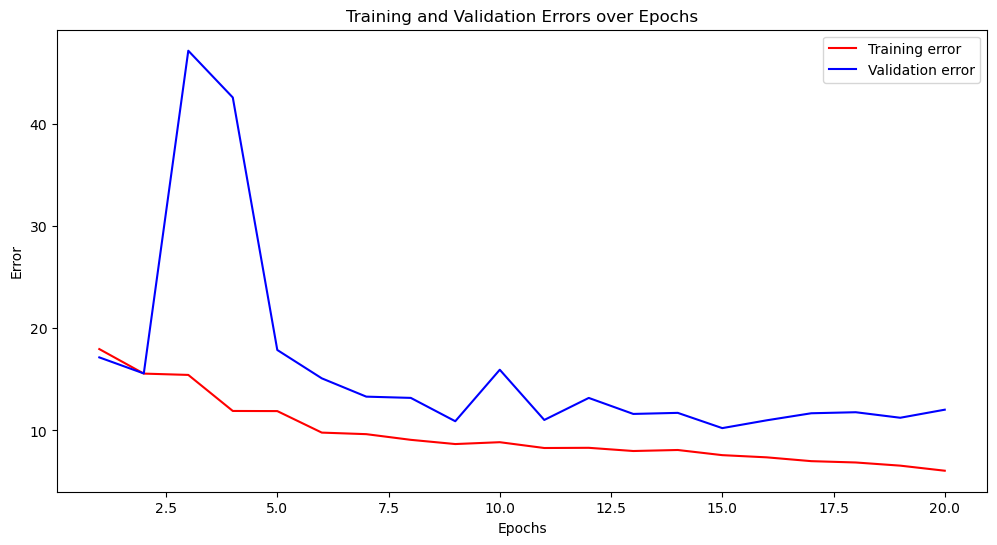

In [9]:

epochs = range(1, len(train_mae_list) + 1)

# Plotting
plt.figure(figsize=(12,6))
plt.plot(epochs, train_mae_list, 'r', label='Training error')
plt.plot(epochs, val_mae_list, 'b', label='Validation error')
plt.title('Training and Validation Errors over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

In [7]:
model.eval()  # Set the model to evaluation mode for test set
total_mae = 0
total_samples = 0

with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device).float()
        labels = labels.to(device).float().view(-1, 1)
        outputs = model(images)
        mae = torch.abs(outputs - labels).sum()
        total_mae += mae.item()
        total_samples += labels.size(0)

test_mae = total_mae / total_samples
print(f'Mean Absolute Error of the model on test images: {test_mae}')

Mean Absolute Error of the model on test images: 12.208390235900879


In [ ]:
#Save Model
path = r'outputs/trained_models/resnet_3d/'
model = torch.save(model.state_dict(), path)

In [8]:
train_mae_list

[17.75001710461032,
 16.08518236366576,
 15.912920168274042,
 15.27269766588591,
 13.702280417339173,
 12.159407208495168,
 10.977868060233245,
 10.460527163076673,
 10.379981180296,
 9.28435252151634,
 9.138612066771998,
 8.612899335104782,
 8.349494470817088,
 12.361669399254236,
 9.725348593840337,
 8.85330683366171,
 7.94079123683401,
 7.432197911010974,
 7.413447001853523,
 7.176692202602437]